In [1]:
# 모듈 및 데이터 로드
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('./drive/MyDrive/machine_learning_data/train_final.csv')

In [3]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


## 1. 데이터 파악 및 시각화 과정

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


<function matplotlib.pyplot.show(*args, **kw)>

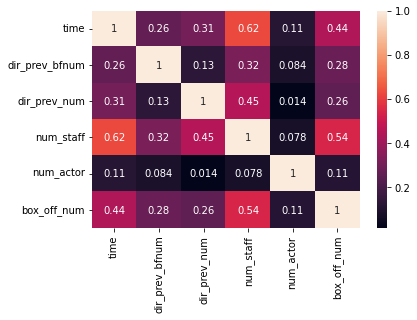

In [5]:
# 숫자로 표시된 변수들 간의 상관관계를 알 수 있음
sns.heatmap(train.corr(),annot=True)
plt.show

In [6]:
# 숫자로 표시된 변수값들의 기술통계량을 알 수 있음 
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


## 2. 데이터 전처리

1) 결측값 처리 

In [7]:
# 결측값 확인 
# 결측값은 dir_prev_bfnum 에만 있고, dir_prev_num 에는 결측값을 0으로 표시되어있음을 알 수 있음 
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [8]:
# 해당 감독이 이 영화를 만들기 전에 제작에 참여한 영화의 관객수를 모르면, 영화의 개수를 0으로 처리해놨기 때문에 dir_prev_bfnum 변수의 결측값을 0으로 처리하는 것이 알맞다고 판단됨
train.fillna(0,inplace=True)
train=train.astype({"dir_prev_bfnum":int})
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1,1,251,2,483387


2) release_time 변수 처리 

In [9]:
# 'release_time' 변수 object->datetime으로 바꾸기 
train["release_time"]=pd.to_datetime(train["release_time"])
train["year"]=train["release_time"].dt.year
train["month"]=train["release_time"].dt.month
train["day"]=train["release_time"].dt.day
train=train.drop("release_time", axis=1)

3) 인코딩

3-1) genre 변수

In [10]:
train["genre"].value_counts()

드라마       221
다큐멘터리      93
멜로/로맨스     78
코미디        53
공포         42
액션         28
느와르        27
애니메이션      21
미스터리       17
SF         13
뮤지컬         5
서스펜스        2
Name: genre, dtype: int64

In [11]:
genre=pd.get_dummies(train["genre"])

In [12]:
train=pd.concat([train,genre], axis=1)
train=train.drop("genre", axis=1)

3-2) screening_rat 변수

In [13]:
train["screening_rat"].value_counts()

청소년 관람불가    204
15세 관람가     202
12세 관람가     102
전체 관람가       92
Name: screening_rat, dtype: int64

In [14]:
screen_rate=pd.get_dummies(train["screening_rat"])

In [15]:
train=pd.concat([train,screen_rate], axis=1)
train=train.drop("screening_rat", axis=1)

3-3) distributor 변수


In [16]:
# distributor 변수 안에는 너무 많은 다른 변수들이 있음을 알 수 있음
train["distributor"].value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

In [17]:
# 가장 많이 나온 6개의 제작사 
train["distributor"].value_counts()[:5]

CJ 엔터테인먼트    54
롯데엔터테인먼트     52
(주)NEW       30
(주)마운틴픽쳐스    29
(주)쇼박스       26
Name: distributor, dtype: int64

In [18]:
# 가장 많이 나온 6개의 제작사를 제외하고는 모두 기타로 처리한다 
distributors = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributors:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))

In [19]:
distributor=pd.get_dummies(train['distributor'])

In [20]:
train=pd.concat([train,distributor], axis=1)
train=train.drop('distributor', axis=1)

4) 필요없는 칼럼 지우기

In [21]:
# 같은 감독의 작품이라고 하더라도 개봉날짜에 따라서 dir_prev_bfnum,dir_prev_num,num_staff,num_actor 이 점점 증가하므로 director 변수를 제거하는것이 맞다고 판단함 
train[train["director"]=="홍상수"]

,title,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,...,12세 관람가,15세 관람가,전체 관람가,청소년 관람불가,(주)NEW,(주)마운틴픽쳐스,(주)쇼박스,CJ 엔터테인먼트,기타,롯데엔터테인먼트
15,자유의 언덕,67,홍상수,0,0,52,3,39317,2014,9,...,0,0,0,1,0,0,0,0,1,0
19,하하하,115,홍상수,0,0,74,9,57029,2010,5,...,0,0,0,1,0,0,0,0,1,0
115,북촌방향,79,홍상수,0,0,55,5,46212,2011,9,...,0,0,0,1,0,0,0,0,1,0
164,지금은맞고그때는틀리다,121,홍상수,39317,1,16,2,80734,2015,9,...,0,0,0,1,1,0,0,0,0,0
331,다른나라에서,89,홍상수,0,0,70,2,31101,2012,5,...,0,0,0,1,0,0,0,0,1,0
506,우리 선희,89,홍상수,0,0,8,6,69122,2013,9,...,0,0,0,1,0,0,0,0,1,0
523,옥희의 영화,80,홍상수,0,0,57,3,37122,2010,9,...,0,0,0,1,0,0,0,0,1,0


In [22]:
# title 변수도 관객수에 관여하지 않으므로 , title과 director 변수를 제거함
train = train.drop(columns=['title','director'])

In [23]:
train

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,day,SF,...,12세 관람가,15세 관람가,전체 관람가,청소년 관람불가,(주)NEW,(주)마운틴픽쳐스,(주)쇼박스,CJ 엔터테인먼트,기타,롯데엔터테인먼트
0,96,0,0,91,2,23398,2012,11,22,0,...,0,0,0,1,0,0,0,0,0,1
1,130,1161602,2,387,3,7072501,2015,11,19,0,...,0,0,0,1,0,0,1,0,0,0
2,123,220775,4,343,4,6959083,2013,6,5,0,...,0,1,0,0,0,0,1,0,0,0
3,101,23894,2,20,6,217866,2012,7,12,0,...,0,0,1,0,1,0,0,0,0,0
4,108,1,1,251,2,483387,2010,11,4,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,111,3833,1,510,7,1475091,2014,8,13,0,...,0,0,0,1,1,0,0,0,0,0
596,127,496061,1,286,6,1716438,2013,3,14,0,...,0,1,0,0,0,0,1,0,0,0
597,99,0,0,123,4,2475,2010,9,30,0,...,0,0,0,1,0,1,0,0,0,0
598,102,0,0,431,4,2192525,2015,5,14,0,...,0,1,0,0,0,0,0,1,0,0


5) test 데이터셋도 train과 똑같이 적용해준다

In [24]:
test=pd.read_csv('./drive/MyDrive/machine_learning_data/test_final.csv')

In [25]:
test.fillna(0,inplace=True)
test=test.astype({"dir_prev_bfnum":int})

test["release_time"]=pd.to_datetime(test["release_time"])
test["year"]=test["release_time"].dt.year
test["month"]=test["release_time"].dt.month
test["day"]=test["release_time"].dt.day
test=test.drop("release_time", axis=1)

genre2=pd.get_dummies(test["genre"])
test=pd.concat([test,genre2], axis=1)
test=test.drop("genre", axis=1)


screen_rate2=pd.get_dummies(test["screening_rat"])
test=pd.concat([test,screen_rate2], axis=1)
test=test.drop("screening_rat", axis=1)


distributors2 = test.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributors2:
        return distributor
    else:
        return '기타'

test['distributor'] = test['distributor'].apply(lambda x : func(x))

distributor2=pd.get_dummies(test['distributor'])
test=pd.concat([test,distributor2], axis=1)
test=test.drop('distributor', axis=1)


title=test[["title"]]
test = test.drop(columns=['title','director'])

6) 데이터 분포 모양에 따라 log 값 취하기 ( skewness 가 1보다 큰 값이면 log 취해주기 )

In [26]:
# target의 skewness 가 1보다 크므로 log 를 취해준다  
y_data= train["box_off_num"]
print(y_data.skew())
log_y_data=np.log1p(y_data)
print(log_y_data.skew())

4.332117702173375
0.13382333522771098


In [27]:
# feature의 skrewness
print(train["time"].skew())
print(train["dir_prev_bfnum"].skew())
print(train["dir_prev_num"].skew())
print(train["num_staff"].skew())
print(train["num_actor"].skew())

0.34564875244035914
6.188970579012462
1.2527617736042533
1.2334523329928717
2.9506678068097965


In [28]:
# feature의 skrewness중 1보다 큰 값에 log를 취해줌
train["dir_prev_bfnum"]=np.log1p(train["dir_prev_bfnum"])
train["dir_prev_num"]=np.log1p(train["dir_prev_num"])
train["num_staff"]=np.log1p(train["num_staff"])
train["num_actor"]=np.log1p(train["num_actor"])

### 3. 모델 개발 및 학습 & 4. 모델 예측 및 평가

In [29]:
box_num = train.pop('box_off_num')

In [30]:
x = train.values.copy()

In [31]:
y = log_y_data.values.copy()

In [32]:
test= test.values.copy()

In [33]:
x_tr, x_te, y_tr, y_te =train_test_split(x,y,
                                         test_size=0.3,
                                         random_state=42)

### 1) 선형회귀

In [34]:
lr = LinearRegression()
lr.fit(x_tr, y_tr)
pred=lr.predict(x_te)
print(f' 선형회귀의 RMSE score은 ', np.sqrt(mean_squared_error(y_te,pred)))

 선형회귀의 RMSE score은  2.1779363736457853


In [35]:
print("선형회귀 모델을 사용하여  test set으로 예측 수행한 결과")
lr_pred=lr.predict(test)
lr_pred=np.expm1(lr_pred)
lr_pred=pd.DataFrame(lr_pred)
df_lr=pd.concat([title,lr_pred], axis=1)
df_lr=df_lr.rename(columns={"title":"title",0:"box_off_num_선형회귀"})
df_lr

선형회귀 모델을 사용하여  test set으로 예측 수행한 결과


,title,box_off_num_선형회귀
0,용서는 없다,inf
1,아빠가 여자를 좋아해,inf
2,하모니,inf
3,의형제,inf
4,평행 이론,inf
...,...,...
238,해에게서 소년에게,1.694640e+43
239,울보 권투부,3.536737e+07
240,어떤살인,2.989094e+64
241,말하지 못한 비밀,inf


### 2) Decision Tree


In [36]:
tree_model= DecisionTreeRegressor(max_depth=4, random_state=13)
tree_model.fit(x_tr, y_tr)
pred=tree_model.predict(x_te)
print(f' Decision Tree 의 RMSE score은 ', np.sqrt(mean_squared_error(y_te,pred)))

 Decision Tree 의 RMSE score은  2.275423817603037


In [37]:
print("Decision Tree 모델을 사용하여  test set으로 예측 수행한 결과")
tree_pred=tree_model.predict(test)
tree_pred=np.expm1(tree_pred)
tree_pred=pd.DataFrame(tree_pred)
df_tree=pd.concat([title,tree_pred], axis=1)
df_tree=df_tree.rename(columns={"title":"title",0:"box_off_num_decision tree"})
df_tree

Decision Tree 모델을 사용하여  test set으로 예측 수행한 결과


,title,box_off_num_decision tree
0,용서는 없다,1.121760e+06
1,아빠가 여자를 좋아해,8.032828e+05
2,하모니,8.032828e+05
3,의형제,8.032828e+05
4,평행 이론,8.032828e+05
...,...,...
238,해에게서 소년에게,1.945021e+03
239,울보 권투부,8.032828e+05
240,어떤살인,3.015804e+05
241,말하지 못한 비밀,3.015804e+05


### 3)Random Forest

In [38]:
rf_model= RandomForestRegressor(max_depth=4, random_state=13)
rf_model.fit(x_tr, y_tr)
pred=rf_model.predict(x_te)
print(f' Random Forest 의 RMSE score은 ', np.sqrt(mean_squared_error(y_te,pred)))

 Random Forest 의 RMSE score은  2.040197115655825


In [39]:
print("Random Forest 모델을 사용하여  test set으로 예측 수행한 결과")
rf_pred=rf_model.predict(test)
rf_pred=np.expm1(rf_pred)
rf_pred=pd.DataFrame(rf_pred)
df_rf=pd.concat([title,rf_pred], axis=1)
df_rf=df_rf.rename(columns={"title":"title",0:"box_off_num_random forest"})
df_rf

Random Forest 모델을 사용하여  test set으로 예측 수행한 결과


,title,box_off_num_random forest
0,용서는 없다,1.745131e+06
1,아빠가 여자를 좋아해,8.785440e+05
2,하모니,7.068611e+05
3,의형제,1.128789e+06
4,평행 이론,8.644273e+05
...,...,...
238,해에게서 소년에게,1.091469e+03
239,울보 권투부,6.042061e+05
240,어떤살인,6.232418e+05
241,말하지 못한 비밀,4.336200e+05


### 4) XGBoost

In [40]:
xgb_model= XGBRegressor( max_depth=4, random_state=13)
xgb_model.fit(x_tr, y_tr)
pred=xgb_model.predict(x_te)
print(f' XGBoost 의 RMSE score은 ', np.sqrt(mean_squared_error(y_te,pred)))

[03:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 XGBoost 의 RMSE score은  2.035098716917195


In [41]:
print("XGBoost 모델을 사용하여  test set으로 예측 수행한 결과")
xgb_pred=xgb_model.predict(test)
xgb_pred=np.expm1(xgb_pred)
xgb_pred=pd.DataFrame(xgb_pred)
df_xgb=pd.concat([title,xgb_pred], axis=1)
df_xgb=df_xgb.rename(columns={"title":"title",0:"box_off_num_xgboost"})
df_xgb

XGBoost 모델을 사용하여  test set으로 예측 수행한 결과


,title,box_off_num_xgboost
0,용서는 없다,8.908166e+05
1,아빠가 여자를 좋아해,3.743859e+05
2,하모니,2.198967e+05
3,의형제,1.128917e+06
4,평행 이론,1.384408e+06
...,...,...
238,해에게서 소년에게,5.842612e+01
239,울보 권투부,2.087602e+05
240,어떤살인,2.970216e+05
241,말하지 못한 비밀,5.231148e+04


###5) LightGBM

In [42]:
gbm = LGBMRegressor( max_depth=4,random_state=13)
gbm.fit(x_tr, y_tr)
pred=gbm.predict(x_te)
print(f'  LightGBM 의 RMSE score은 ', np.sqrt(mean_squared_error(y_te,pred)))

  LightGBM 의 RMSE score은  1.9511086443505377


In [43]:
print("LightGBM 모델을 사용하여  test set으로 예측 수행한 결과")
gbm_pred=gbm.predict(test)
gbm_pred=np.expm1(gbm_pred)
gbm_pred=pd.DataFrame(gbm_pred)
df_gbm=pd.concat([title,gbm_pred], axis=1)
df_gbm=df_gbm.rename(columns={"title":"title",0:"box_off_num_lightgbm"})
df_gbm

LightGBM 모델을 사용하여  test set으로 예측 수행한 결과


,title,box_off_num_lightgbm
0,용서는 없다,1.889835e+06
1,아빠가 여자를 좋아해,1.030335e+06
2,하모니,1.211822e+06
3,의형제,2.028584e+06
4,평행 이론,2.906177e+06
...,...,...
238,해에게서 소년에게,2.329589e+03
239,울보 권투부,3.279226e+05
240,어떤살인,4.111449e+05
241,말하지 못한 비밀,1.683806e+05


## 최종 결과 
##### 선형회귀의 RMSE는 2.178 이다. 
##### Decision Tree의 2.275 RMSE는 이다.
##### Random Forest의 2.04 RMSE는 이다.
##### XGBoost의 RMSE는 2.035 이다.
##### LightGBM의 RMSE는 1.951 이다.



##### 따라서,  LightGBM 의 RMSE가 가장 작으므로 5개의 모델중에 가장 적합한 모델임을 알 수 있다.

In [44]:
print("LightGBM 모델을 사용하여  test set으로 예측 수행한 결과")
gbm_pred=gbm.predict(test)
gbm_pred=np.expm1(gbm_pred)
gbm_pred=pd.DataFrame(gbm_pred)
df_gbm=pd.concat([title,gbm_pred], axis=1)
df_gbm=df_gbm.rename(columns={"title":"title",0:"box_off_num_lightgbm"})
df_gbm

LightGBM 모델을 사용하여  test set으로 예측 수행한 결과


,title,box_off_num_lightgbm
0,용서는 없다,1.889835e+06
1,아빠가 여자를 좋아해,1.030335e+06
2,하모니,1.211822e+06
3,의형제,2.028584e+06
4,평행 이론,2.906177e+06
...,...,...
238,해에게서 소년에게,2.329589e+03
239,울보 권투부,3.279226e+05
240,어떤살인,4.111449e+05
241,말하지 못한 비밀,1.683806e+05
